In [1]:
#Import dependencies

%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt
from datetime import datetime as dt
from datetime import timedelta 

## Reflect Tables into SQLALchemy ORM

In [3]:
# Import Python SQL toolkit and Object Relational Mapper

import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [4]:
# create engine to hawaii.sqlite

engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model

Base = automap_base()
Base.prepare(engine, reflect=True)

In [7]:
# View all of the classes that automap found

inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [8]:
# Save references to each table

Measurement = Base.classes.measurement
Stations = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB

session = Session(engine)

## Bonus Challenge Assignment: Temperature Analysis II

In [10]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, maximum, and average temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()


In [11]:
# Use the function `calc_temps` to calculate the tmin, tavg, and tmax 
# for a year in the data set

climate_data = calc_temps('2017-01-01', '2017-12-31')[0]
climate_data

(58.0, 74.14387974230493, 87.0)

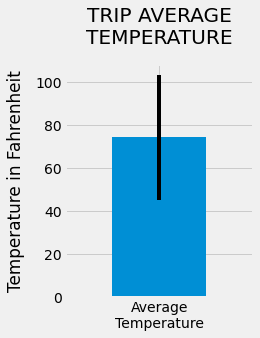

In [12]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title. Use the average temperature for bar height (y value)
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

plt.figure(num=None, figsize=(3,4), dpi=None,                   # Set up plot figure
           facecolor=None, edgecolor=None, frameon=True)

x_axis = 'Average\nTemperature'                                 # Set up x axis

y_axis = climate_data[1]                                        # Set up y axis

plt.bar(x_axis, y_axis, label='Average temperatures',           # Plot bar chart. Add the y error as the difference
        width=.5, yerr=(climate_data[0]-climate_data[2]))       #   between the max and min temperature. 

plt.xlim(-.5, .5)                                               # Add some space to the x axis

plt.title("TRIP AVERAGE\nTEMPERATURE", fontsize='x-large',      # Set up title
           loc='center', pad=20)

plt.ylabel("Temperature in Fahrenheit",                         # Set up y axis label
           fontsize='large', labelpad=10)


plt.savefig("output_charts/average_trip_temperature.png",       # Export chart
            transparent=False)

plt.show()

### Daily Rainfall Average

In [13]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's 
# matching dates. Sort this in descending order by precipitation amount and list the station,
# name, latitude, longitude, and elevation

trip_start_date = '2017-08-01'               # Set variables to start and end date
trip_end_date = '2017-08-07'

    # Get data for the trip data range:
    #    1. Query station ids, names, lat, lobng, elevation, and func.sum of precipitation
    #    2. Filter by station name (JOIN)
    #    3. Filter by date range of trip
    #    4. Group by station
    #    5. Order by sum of precipitation in decending
stmt = session.query(Stations.id, Stations.station, Stations.latitude, Stations.longitude, 
                     Stations.elevation, func.sum(Measurement.prcp)).\
    filter(Measurement.station == Stations.station).\
    filter(Measurement.date >= trip_start_date, Measurement.date <= trip_end_date).\
    group_by(Measurement.station).order_by(func.sum(Measurement.prcp).desc()).statement

    # Create the dataframe and clean up column names
rain_per_station = pd.read_sql_query(stmt, session.bind).\
    rename(columns={'id' : 'Station ID', 'station' : 'Station Name', 
                    'latitude' : 'Latitude', 'longitude' : 'Longitude', 
                    'elevation' : 'Elevation', 'sum_1': 'Total Rainfall'})

rain_per_station

,Station ID,Station Name,Latitude,Longitude,Elevation,Total Rainfall
0,9,USC00516128,21.33310,-157.80250,152.4,0.36
1,3,USC00514830,21.52130,-157.83740,7.0,0.22
2,7,USC00519281,21.45167,-157.84889,32.9,0.06
3,1,USC00519397,21.27160,-157.81680,3.0,0.04
4,6,USC00519523,21.33556,-157.71139,19.5,0.00


In [14]:
# Use this function to calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.round(func.avg(Measurement.tobs), 1), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()


In [20]:
# calculate the daily normals for your trip push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
trip_start_date = '2017-08-01'               # Set variables to start and end date
trip_end_date = '2017-08-07'


# Use the start and end date to create a range of dates

trip_start_date_dt_object = dt.strptime(trip_start_date, '%Y-%m-%d')
trip_end_date_dt_object = dt.strptime(trip_end_date, '%Y-%m-%d')

trip_date_range = trip_end_date_dt_object - trip_start_date_dt_object

# Use the `daily_normals` function to calculate the normals for each date string 
# and append the results to a list called `normals`.
normals = [['Date', 'Min Temp', 'Avg Temp', 'Max Temp']]

for i in range(trip_date_range.days+1):
    
    date = (trip_start_date_dt_object + timedelta(days=i)).strftime("%m-%d")
    trip_date = (trip_start_date_dt_object + timedelta(days=i)).strftime("%Y-%m-%d")
    day_set= list(daily_normals(date)[0])
    day_set.insert(0, trip_date)
    normals.append(day_set)

normals

[['Date', 'Min Temp', 'Avg Temp', 'Max Temp'],
 ['2017-08-01', 67.0, 75.5, 83.0],
 ['2017-08-02', 68.0, 75.6, 84.0],
 ['2017-08-03', 70.0, 76.6, 85.0],
 ['2017-08-04', 69.0, 76.7, 84.0],
 ['2017-08-05', 69.0, 76.1, 82.0],
 ['2017-08-06', 67.0, 76.3, 83.0],
 ['2017-08-07', 71.0, 77.2, 83.0]]

In [21]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index

trip_temp_df=pd.DataFrame(normals[1:], columns=normals[0])

trip_temp_df.set_index('Date', drop=True, inplace=True)
trip_temp_df

,Min Temp,Avg Temp,Max Temp
Date,,,
2017-08-01,67.0,75.5,83.0
2017-08-02,68.0,75.6,84.0
2017-08-03,70.0,76.6,85.0
2017-08-04,69.0,76.7,84.0
2017-08-05,69.0,76.1,82.0
2017-08-06,67.0,76.3,83.0
2017-08-07,71.0,77.2,83.0


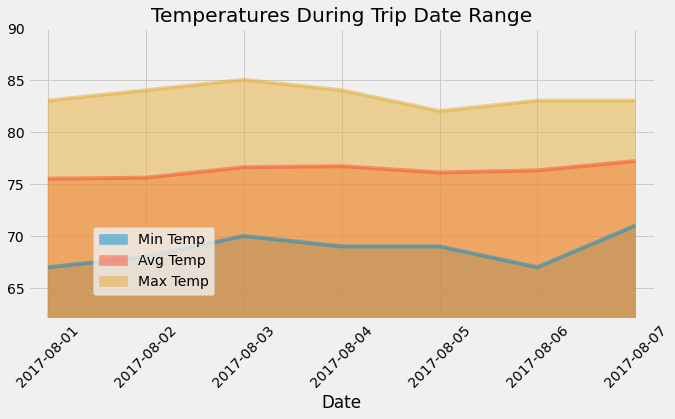

In [31]:
# Plot the daily normals as an area plot with `stacked=False`

trip_temp_df.plot.area(figsize=(10, 5),                                # Area plot
                       stacked=False,                                  # Stacked = False
                       title='Temperatures During Trip Date Range', 
                       ylim=(min(trip_temp_df['Min Temp'])-5, max(trip_temp_df['Max Temp'])+5), 
                       xlim=(-.2, len(trip_temp_df)-.8),               # Automatically adjust x and y limits
                       rot=45,                                         # Put date labels at angles
                       legend=False                                    # Turn off legend because plt.legend
                      )                                                #    has better options below

plt.legend(loc='center', bbox_to_anchor=(.2, .2))                      # Plot legend 

plt.savefig("output_charts/temps_during_trip_date_range.png",          # Export chart
            transparent=False)

plt.show()

## Close Session

In [32]:
# Close Session
session.close()